# Numeričko rješavanje sustava linearnih jednadžbi i inicijalnog problema za ODJ

## Sadržaj
1. [Numeričko rješavanje sustava linearnih jednadžbi](#Numericko1)

 1.1. [Uvod i motivacija](#uvod1)  
 
 1.2. [Pozadina metodâ](#pozadina)  
 
 1.3. [Metode](#metode) - <b>ispraviti matricne zapise da odgovaraju ZR</b>  
   1.3.1. [Jacobijeva metoda](#Jacobi)  
   1.3.2. [Gauss–Seidelova metoda](#Gauss)  
   1.3.3. [SOR metoda](#SOR)
    
 1.4. [Testiranje i usporedba metoda na primjerima - Stieltjes matrica](#Testiranje1)    

 1.5. [Zaključak](#Zakljucak1)
    
    
2. [Numeričko rješavanje inicijalnog problema za ODJ](#Numericko2)
    
 2.1. [Uvod](#uvod2)
    
 2.2. [Jednokoračne metode](#jednokoracne)  
   2.2.1. [Eulerova metoda](#Euler)  
   2.2.2. [Trapezna metoda](#trapez)     
   2.2.3. [Runge-Kuttina metoda](#runge)  
   
 2.3. [Višekoračne metode](#visekoracne)     
   2.3.1. [Adams–Bashforthova metoda](#Adams)
    
 2.4. [Testiranje i usporedba na primjerima](#Testiranje2)
    
 2.5. [Zaključak](#Zakljucak2)
    

3. [Literatura](#Literatura)

## 1. Numeričko rješavanje sustava linearnih jednadžbi <a name="Numericko1"></a>

### 1.1. Uvod i motivacija <a name="uvod1"></a>

Jedan od osnovnih problema numeričke matematike je rješavanje linearnih sustava jednadžbi. U ovom eseju istraživat ćemo metode za rješavanje kvadratnih $n\times n$ sustava, odnosno sustava od $n$ jednadžbi s $n$ nepoznanica,

$$
\begin{equation}
a_{11}x_{1} + a_{12}x_{2} + ... + a_{1j}x_{j} + ... + a_{1n}x_{n} = b_{1}\\
a_{21}x_{1} + a_{22}x_{2} + ... + a_{2j}x_{j} + ... + a_{2n}x_{n} = b_{2}\\
\vdots\\
a_{i1}x_{1} + a_{i2}x_{2} + ... + a_{ij}x_{j} + ... + a_{in}x_{n} = b_{i}\\
\vdots\\
a_{n1}x_{1} + a_{n2}x_{2} + ... + a_{nj}x_{j} + ... + a_{nn}x_{n} = b_{n}\\
\end{equation}
$$

Matricu $A=(a_{ij})_{i,j=1}^{n}$ nazivamo <b>matrica sustava</b>, a njeni elementi su <b>koeficijenti sustava</b>. Vektor $b=(b_{i})_{i=1}^{n}$ naziva se <b>vektor desne strane</b>. Trebamo odrediti <b>vektor nepoznanica</b> $x=(x_{i})_{i=1}^{n}$ tako da vrijedi $Ax=b$. Od sada nadalje, podrazumijevat ćemo da je matrica sustava kvadratna i regularna, osim ako eksplicitno ne kažemo drugačije.

Iz linearne algebre znamo da je rješavanje sustava $Ax=b$ za teorijsku matematiku gotovo trivijalan problem, posebno u slučaju kada je matrica sustava kvadratna i regularna. Rješenje $x$ dano je formulom $x=A^{-1}b$, gdje je $A^{-1}$ inverzna matrica od $A$ ($AA^{-1}=A^{-1}A=I$). Pri tome postoje eksplicitne formule i za elemente matrice $A^{-1}$ i za samo rješenje $x$. Osim toga, Gaussova metoda eliminacija dolazi do rješenja $x$ u $O(n^{3})$ elementarnih operacija (gdje su elementarne operacije: zbrajanje, oduzimanje, množenje i dijeljenje).

Dakle, znamo da rješenje $x=A^{-1}b$ postoji, jedinstveno je i postoji jednostavan algoritam koji to rješenje eksplicitno računa koristeći konačno mnogo jednostavnih aritmetičkih operacija. No, problem je u tome što je racionalna aritmetika bitno sporija od realne (približne) aritmetike, koja je podržana u hardveru.

Iz tog razloga, uvodimo iterativne metode. Iterativne metode ne daju egzaktno rješenje, nego aproksimaciju tog rješenja. Pokazat će se da pomoću iterativnih metoda ne znamo egzaktno rješenje, ali znamo koliko smo "blizu" egzaktnom rješenju.

Metode koje ćemo navesti i objasniti su Jacobijeva, Gauss–Seidelova i SOR (<i>successive over-relaxation</i>) metoda.

### 1.2. Pozadina metodâ <a name="pozadina"></a>

Pretpostavimo da rješavamo sustav $Ax=b$ za koji vrijedi $\det A\neq0$. Budući da umjesto egzaktnog rješenja $x$, moramo koristiti neku aproksimaciju $\tilde{x}$, moramo imati način procjene kvalitete aproksimacije. Jedan način je izračunati normu $\delta x$, gdje je $\delta x = \tilde{x} - x$, no budući da je $x$ nepoznanica, to nije moguće. Drugi način je da izračunamo rezidual

$$ r = b - A\tilde{x} \label{eq:1}\tag{1} $$

Reći ćemo da je $\tilde{x}$ dobra aproksimacija od $x$ ako je, u nekoj normi $\|\cdot\|$, vrijednost $\varepsilon:=\frac{\|r\|}{\|b\|}$ dovoljno mala.

Takav kriterij možemo opravdati činjenicom da je iz $\eqref{eq:1}$
$$ A\tilde{x} = \tilde{b}\equiv b-r, \frac{\|\tilde{b}-b\|}{\|b\|}=\frac{\|r\|}{\|b\|}=\varepsilon.$$

Kažemo da $\tilde{x}$ egzaktno rješava sustav koji je blizak zadanom, s kontroliranom razlikom u desnoj strani sustava, vektoru $b$.

Prethodna diskusija motivira nas da potražimo i drugačije pristupe za rješavanje linearnog sustava $Ax=b$. Primijetimo da ne moramo nužno težiti pronalaženju egzaktnog rješenja. Dakle, želimo <i>dovoljno dobru</i> aproksimaciju $\tilde{x}\approx A^{-1}b$. Zbog toga ima smisla pokušati konstruirati niz $x^{(0)},x^{(1)},x^{(2)},...,x^{(k)},...$ vektora sa sljedećim svojstvima:
- Za svaki $k\in\mathbb{N}$ formula za računanje $x^{(k)}$ je jednostavna i matrica $A$ se koristi samo kao funkcijski potprogram koji računa $v\mapsto f\left(A\right)v$, gdje je $v$ vektor, a $f\left(A\right)$ označava $A,A^{*},A^{T}$ ili neki dio od $A$ (npr. $\operatorname{diag}A$, gornji ili donji trokut od $A$ i sl.)
- $x^{(k)}$ teži prema $x=A^{-1}b$ i za neki $k$ (obično $k\ll n$), $x^{(k)}$ je prihvatljiva aproksimacija za $x$.

Ova svojstva su namjerno dana u nepreciznom obliku. Detalji koji ovise o konkretnom problemu i ko konkretnom načinu konstrukcije niza $(x^{(k)}$  bit će dani kada budemo opisivali metodu (metode).

Napišimo matricu $A$ kao $A=M-N$, gdje je $M$ regularna matrica i $M^{-1}A\approx I$. Imamo:

$$Mx=Nx+b,\;\text{ dakle }\; x=M^{-1}Nx+M^{-1}b \label{eq:2}\tag{2}$$

Označimo $F:=M^{-1}N$ i $c:=M^{-1}b$. To je problem fiksne točke $x=Fx+c$, sa $F=M^{-1}N=M^{-1}\left(M-A\right)=I-M^{-1}A$ pa je prirodno pokušati jednostavne iteracije:

$$ x^{(k+1)}=Fx^{(k)}+c. \label{eq:3}\tag{3} $$

Ubacivanjem $F=I-M^{-1}A$ i $c=M^{-1}b$ vidimo da se iteracije iz $\eqref{eq:3}$ mogu zapisati i kao

$$ x^{(k+1)}=x^{(k)}+M^{-1}r_{k},\;\text{gdje je}\;\; r_{k}=Ax^{(k)} \label{eq:4}\tag{4}$$

Intuitivno, ako smo $M$ odabrali tako da znamo koristiti $M^{-1}$ i tako da je $M^{-1}\approx A^{-1}$, onda je 

$$ x^{(k+1)}=x^{(k)} + M^{-1}r_{k}\approx x^{(k)} + A^{-1}r_{k}= x^{(k)} + x - x^{(k)}=x.$$

Kažemo da je $M$ <b>prekondicioner</b> za $A$ u smislu da $M^{-1}$ aproksimira $A^{-1}$. Ako imamo dobar izbor matrice $M$, onda polazni sustav $Ax=b$ možemo zamijeniti ekvivalentnim $\left(M^{-1}A\right)x=M^{-1}b$ čija matrica koeficijenata $M^{-1}A$ ima bolja svojstva od $A$.

Najveći dio problema je u tome kako odabrati rastav matrice $A$ kao $A=M-N$ koji će za neke klase problema osigurati konvergenciju. Za Jacobijevu, Gauss–Seidelovu i SOR metodu ti će rastavi biti izvedeni iz sljedeće reprezentacije matrice $A$:

$$ A = D\left(I-L-U\right) \label{eq:5}\tag{5}$$

gdje je $D=\operatorname{diag}(A)$, $L$ je strogo donje trokutatsta matrica čiji su elementi strogo donji elementi matrice $-A$, a $U$ je strogo gornje trokutasta čiji su elementi strogo donji elementi matrice $-A$. Također, koristit ćemo i sljedeći rastav:
$$ A = D - \hat{L} - \hat{U},\; \hat{L}=DL,\; \hat{U}=DU$$

### 1.3. Metode <a name="metode"></a>

####  1.3.1. Jacobijeva metoda <a name="Jacobi"></a>

Jacobijeva metoda definirana je za matricu $A\in\mathbb{M}_{n}$ za koju je $a_{ii}\neq0, \forall i=1,...,n$. Za matricu $M$ ćemo uzeti dijagonalu od $A$, $M=\operatorname{diag}(A)$, pa je $N$ izvandijagonalni dio od $-A$. Matricu $F=D^{-1}(D-A)$ označimo sa $J$, gdje je u terminima $A = D\left(I-L-U\right)$:

$$ J=L+U \label{eq:6}\tag{6}$$



Jacobijeve iteracije $x^{(k+1)}=Jx^{(k)}+D^{-1}b$ po elementima glase:

$$ x_i^{(k+1)}=\frac{1}{a_{ii}}\bigl(b_{i}-\sum_{j=1\\j\neq i}^{n}a_{ij}x_{j}^{(k)}\bigr)\label{eq:7}\tag{7}$$

In [2]:
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
from PIL import Image
import scipy as sp

Jacobijev algoritam:

In [40]:
def jacobi(x, A, b, tolerance):
    """" Računanje približnog rješenja sustava linearnih jednadžbi Jacobijevom metodom
    
    Argumenti funkcije:
    x -- početna aproksimacija rješenja
    A -- dijagonalno dominantna matrica
    b -- vektor desne strane sustava
    tolerance -- kriterij konvergencije
    """
    
    # A je kvadratna pa nije vazno uzimamo li broj redaka ili stupaca
    n = len(x)
    
    # dekompozicija matrice A
    D = np.linalg.inv(np.diag(np.diag(A)))
    L = np.tril(A, k=-1)
    U = np.triu(A, k=1)
    
    #x = Fx+c
    F = (-D) @ (L+U)
    c = D @ b
    
    # vektor reziduala svake iteracije
    residual = np.array([np.linalg.norm(b - A@x)])
    
    # matrica koja u retku i ima aproksimaciju dobivenu u i-toj iteraciji 
    approximations = np.array(x)
    k = 0
    while residual[k] >= tolerance:
        k = k + 1
        x = F@x + c
        residual = np.append(residual, np.linalg.norm(b - A@x))
        approximations = np.append(approximations, x).reshape(k+1, n)
    return x, residual, approximations

#### 1.3.2. Gauss–Seidelova metoda <a name="Gauss"></a>

Gledajući posljednju formulu Jacobijeve metode, možemo primijetiti da su u trenutku računanja $x_{i}^{(k+1)}$, vrijednosti $x_{1}^{(k+1)},...,x_{i-1}^{(k+1)}$ već poznate. Budući da očekujemo da naše iteracije konvergiraju, razumno je očekivati da su $x_{1}^{(k+1)},...,x_{i-1}^{(k+1)}$ bolje vrijednosti od $x_{1}^{(k)},...,x_{i-1}^{(k)}$. Iz tog razloga uvodimo sljedeću formulu za računanje $x^{(k+1)}$:

$$ x_i^{(k+1)}=\frac{1}{a_{ii}}\bigl(b_{i}-\sum_{j=1}^{i-1}a_{ij}x_{j}^{(k+1)}-\sum_{j=i+1}^{n}a_{ij}x_{j}^{(k)}\bigr),\; i=1,...,n\label{eq:8}\tag{8}$$

U terminima $A = D\left(I-L-U\right)$ otprije, metoda glasi:

$$ x^{(k+1)}=Gx^{(k)}+\left(I-L\right)^{-1}D^{-1}b,\; G = \left(I-L\right)^{-1}U\label{eq:9}\tag{9}$$

Gauss–Seidelov algoritam:

In [41]:
def gaussSeidel(x, A, b, tolerance):
    """" Računanje približnog rješenja sustava linearnih jednadžbi Gauss-Seidelovom metodom
    
    Argumenti funkcije:
    x -- početna aproksimacija rješenja
    A -- dijagonalno dominantna matrica
    b -- vektor desne strane sustava
    tolerance -- kriterij konvergencije
    """
    
    # A je kvadratna pa nije vazno uzimamo li broj redaka ili stupaca
    n = len(A)
    
    # dekompozicija matrice A
    D = np.diag(np.diag(A))
    L = np.tril(A, k=-1)
    U = np.triu(A, k=1)
    D = np.linalg.inv(D + L)
    
    #x = Fx + c
    F = (-D) @ U
    c = D @ b
    
    # vektor reziduala svake iteracije
    residual = np.array([np.linalg.norm(b - A@x)])
    
    # matrica koja u retku i ima aproksimaciju dobivenu u i-toj iteraciji 
    approximations = np.array(x)
    k = 0
    while residual[k] >= tolerance:
        k = k + 1
        x = F@x + c
        residual = np.append(residual, np.linalg.norm(b - A@x))
        approximations = np.append(approximations, x).reshape(k+1, n)
    return x, residual, approximations

#### 1.3.3. SOR metoda <a name="SOR"></a>

SOR metoda je varijacija na Gauss–Seidelovu metodu, koja u konačnici dovodi do brže konvergencije. Analognim zaključivanjem za bilo koju sporo konvergirajuću metodu možemo kreirati bržu metodu. Ideja SOR metode je jednostavna: u Gauss–Seidelovu metodu ubacimo jedan slobodan parametar $\omega\in\mathbb{R}$ te pokušamo namjestiti $\omega$  kako bismo dobili bržu konvergenciju. Pri tome zadržavamo osnovnu ideju Gauss–Seidelove metode – koristimo najsvježije podatke:

$$ x_i^{(k+1)}=\left(1-\omega\right)x_{i}^{(k)} + \frac{\omega}{a_{ii}}\bigl(b_{i}-\sum_{j=1}^{i-1}a_{ij}x_{j}^{(k+1)}-\sum_{j=i+1}^{n}a_{ij}x_{j}^{(k)}\bigr),\; i=1,...,n\label{eq:10}\tag{10}$$

Sada, u terminima $A = D\left(I-L-U\right)$, metoda glasi:

$$ x^{(k+1)}=Sx^{(k)}+\omega\left(I-\omega L\right)^{-1}D^{-1}b,\; S = \left(I-\omega L\right)^{-1}\bigl(\left(1-\omega\right)I+\omega U\bigr)\label{eq:11}\tag{11}$$

In [42]:
def sor(x, A, b, omega, tolerance):
    """" Računanje približnog rješenja sustava linearnih jednadžbi SOR metodom
    
    Argumenti funkcije:
    x -- početna aproksimacija rješenja
    A -- dijagonalno dominantna matrica
    b -- vektor desne strane sustava
    omega -- parametar relaksacije
    tolerance -- kriterij konvergencije
    """
    
    
    # A je kvadratna pa nije vazno uzimamo li broj redaka ili stupaca
    n = len(A)
    
    # dekompozicija matrice A
    D = np.diag(np.diag(A))
    L = np.tril(A, k=-1)
    U = np.triu(A, k=1)
    L = np.linalg.inv(D + omega*L)
    U = (1-omega)*D - omega*U
    
    #x = Fx + c
    F = L @ U
    c = (omega*L) @ b
    
    # vektor reziduala svake iteracije
    residual = np.array([np.linalg.norm(b - A@x)])
    
    # matrica koja u retku i ima aproksimaciju dobivenu u i-toj iteraciji 
    approximations = np.array(x)
    k = 0
    while residual[k] >= tolerance:
        k = k + 1
        x = F@x + c
        residual = np.append(residual, np.linalg.norm(b - A@x))
        approximations = np.append(approximations, x).reshape(k+1, n)
    return x, residual, approximations

Za odabir optimalnog omege, prije testiranja ispitat ćemo moguće kandidate i izabrati optimalnu vrijednost. Sad se možemo pitati: zar ćemo testirati za sve realne brojeve? No, odabir će nam olakšati Kahanov teorem:

$\text{Neka je S matrica SOR metode s parametrom }\omega. \text{ Tada je} \operatorname{spr}(S)\geq|\omega-1|.\text{ Dakle, za konvergenciju SOR metode nužno je da je } \omega\in(0,2)$.

### 1.4. Testiranje i usporedba metoda na primjerima – Stieltjes matrica<a name="Testiranje1"></a>

Testiranje Jacobijeve, Gauss–Seidelove i SOR metode provest ćemo na nekoliko različitih matrica. Jedna od njih je jedan primjer Stieltjesove matrice. Stieltjesova matrica je realna simetrična pozitivno definitna matrica kojoj su elementi izvan dijagonale nepozitivni ($\leq 0$). Testiranje ćemo provesti s vektorom desne strane takvim da je egzaktno rješenje vektor jedinica. Također, dovoljna točnost će nam biti $1\text{e-8}$. Početna aproksimacija neka bude nulvektor.

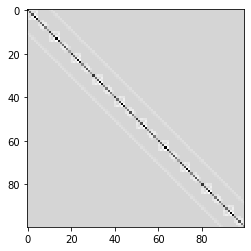

In [43]:
# kriterij konvergencije
tolerance = 1e-8

stieltjes = np.genfromtxt('stieltjes.txt').reshape(100,100)
plt.imshow(stieltjes, interpolation='nearest',cmap='gray_r')
plt.show()

In [44]:
# hardkodirajmo korisne vektore
one = np.ones(len(stieltjes))
rhs = stieltjes @ one
unknown = np.zeros(len(stieltjes))
xAxis = np.arange(1,101)

Najprije pronađimo optimalan $\omega\in(0,2)$ za SOR metodu. Za naše potrebe, dovoljno će biti uzeti realan broj $\omega$ s najviše dvije decimale.

In [46]:
omegas = np.linspace(0.01,1.99,199)
stepNumber = np.zeros(len(omegas))
x = np.zeros((len(omegas),len(rhs)))
for i in range(len(omegas)):
    print('Računam SOR metodom za omega = ', omegas[i])
    %time x[i], residual, approximation = sor(unknown, stieltjes, rhs, omegas[i], tolerance)
    stepNumber[i] = len(residual)
    print('Broj koraka potreban za dostizanje tražene točnosti: ', stepNumber[i])

Računam SOR metodom za omega =  0.01
Wall time: 31.2 s
Broj koraka potreban za dostizanje tražene točnosti:  11477.0
Računam SOR metodom za omega =  0.02
Wall time: 7.6 s
Broj koraka potreban za dostizanje tražene točnosti:  5711.0
Računam SOR metodom za omega =  0.03
Wall time: 2.94 s
Broj koraka potreban za dostizanje tražene točnosti:  3788.0
Računam SOR metodom za omega =  0.04
Wall time: 1.56 s
Broj koraka potreban za dostizanje tražene točnosti:  2827.0
Računam SOR metodom za omega =  0.05
Wall time: 937 ms
Broj koraka potreban za dostizanje tražene točnosti:  2250.0
Računam SOR metodom za omega =  0.060000000000000005
Wall time: 559 ms
Broj koraka potreban za dostizanje tražene točnosti:  1866.0
Računam SOR metodom za omega =  0.06999999999999999
Wall time: 328 ms
Broj koraka potreban za dostizanje tražene točnosti:  1591.0
Računam SOR metodom za omega =  0.08
Wall time: 130 ms
Broj koraka potreban za dostizanje tražene točnosti:  1385.0
Računam SOR metodom za omega =  0.09
Wall

Wall time: 3.06 ms
Broj koraka potreban za dostizanje tražene točnosti:  84.0
Računam SOR metodom za omega =  0.8200000000000001
Wall time: 7.04 ms
Broj koraka potreban za dostizanje tražene točnosti:  82.0
Računam SOR metodom za omega =  0.8300000000000001
Wall time: 4.05 ms
Broj koraka potreban za dostizanje tražene točnosti:  80.0
Računam SOR metodom za omega =  0.8400000000000001
Wall time: 5.49 ms
Broj koraka potreban za dostizanje tražene točnosti:  78.0
Računam SOR metodom za omega =  0.85
Wall time: 4.53 ms
Broj koraka potreban za dostizanje tražene točnosti:  77.0
Računam SOR metodom za omega =  0.86
Wall time: 10.1 ms
Broj koraka potreban za dostizanje tražene točnosti:  75.0
Računam SOR metodom za omega =  0.87
Wall time: 8.24 ms
Broj koraka potreban za dostizanje tražene točnosti:  73.0
Računam SOR metodom za omega =  0.88
Wall time: 3.93 ms
Broj koraka potreban za dostizanje tražene točnosti:  72.0
Računam SOR metodom za omega =  0.89
Wall time: 4.01 ms
Broj koraka potreba

Wall time: 6.06 ms
Broj koraka potreban za dostizanje tražene točnosti:  72.0
Računam SOR metodom za omega =  1.71
Wall time: 1.33 ms
Broj koraka potreban za dostizanje tražene točnosti:  75.0
Računam SOR metodom za omega =  1.72
Wall time: 3.02 ms
Broj koraka potreban za dostizanje tražene točnosti:  78.0
Računam SOR metodom za omega =  1.73
Wall time: 4.01 ms
Broj koraka potreban za dostizanje tražene točnosti:  81.0
Računam SOR metodom za omega =  1.74
Wall time: 1.98 ms
Broj koraka potreban za dostizanje tražene točnosti:  84.0
Računam SOR metodom za omega =  1.75
Wall time: 8.06 ms
Broj koraka potreban za dostizanje tražene točnosti:  88.0
Računam SOR metodom za omega =  1.76
Wall time: 5.53 ms
Broj koraka potreban za dostizanje tražene točnosti:  92.0
Računam SOR metodom za omega =  1.77
Wall time: 1.02 ms
Broj koraka potreban za dostizanje tražene točnosti:  97.0
Računam SOR metodom za omega =  1.78
Wall time: 10.1 ms
Broj koraka potreban za dostizanje tražene točnosti:  101.0
R

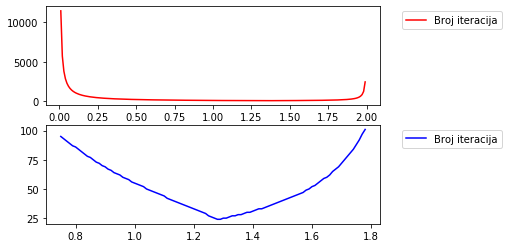

In [51]:
fig1, (ax1, ax2) = plt.subplots(2,1)

# Broj iteracija za svaku vrijednost vektora omegas
ax1.plot(omegas, stepNumber, label='Broj iteracija',color='red')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Broj iteracija za one omege za koje se tražena točnost postiže u manje od 100 koraka
ax2.plot(omegas[74:178], stepNumber[74:178], label='Broj iteracija', color='blue')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Možemo vidjeti da za $\omega=1.28$ i $\omega=1.29$ dobivamo traženo približno rješenje u najmanje koraka, točnije $24$. Jednostavnosti radi, neka je $\omega=1.28$.

In [11]:
print('Optimalan omega: ', omegas[np.argmin(stepNumber)])
print('Broj koraka za optimalan omega: ', stepNumber.min())

Optimalan omega:  1.28
Broj koraka za optimalan omega:  24.0


In [56]:
# rješavanje sustava koristeći Jacobijevu metodu
print("Vrijeme potrebno za dobivanje približno rješenje Jacobijevom metodom: ")
%time xJacobi, resJacobi, approxJacobi = jacobi(unknown, stieltjes, rhs, tolerance)

# rješavanje sustava koristeći Gauss-Seidelovu metodu
print("Vrijeme potrebno za dobivanje približno rješenje Gauss-Seidelovom metodom: ")
%time xGS, resGS, approxGS = gaussSeidel(unknown, stieltjes, rhs, tolerance)

# rješavanje sustava koristeći SOR metodu
print("Vrijeme potrebno za dobivanje približno rješenje SOR metodom: ")
%time xSOR, resSOR, approxSOR = sor(unknown, stieltjes, rhs, omegas[np.argmin(stepNumber)], tolerance)

Vrijeme potrebno za dobivanje približno rješenje Jacobijevom metodom: 
Wall time: 0 ns
Vrijeme potrebno za dobivanje približno rješenje Gauss-Seidelovom metodom: 
Wall time: 895 µs
Vrijeme potrebno za dobivanje približno rješenje SOR metodom: 
Wall time: 0 ns


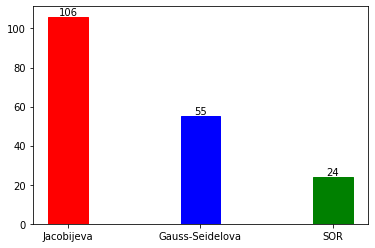

In [58]:
fig2, ax = plt.subplots()
labels = [len(resJacobi), len(resGS), len(resSOR)]
barlist = ax.bar(['Jacobijeva', 'Gauss-Seidelova', 'SOR'], labels, width=0.3)
barlist[0].set_color('r')
barlist[1].set_color('b')
barlist[2].set_color('g')

bars = ax.patches

for bar, label in zip(bars, labels):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, label,
            ha='center', va='bottom')
plt.show()

Također primijetimo da za $\omega=1$, i SOR metoda daje traženo približno rješenje u $55$ koraka. To je, naravno, zato što je za $\omega=1$, SOR metoda zapravo Gauss-Seidelova metoda.

Pokretanjem koda u idućoj ćeliji, dobit ćemo slikovni prikaz iteracija. Budući da Jacobijeva metoda daje približno rješenje u 105 iteracija, Gauss-Seidelova u 55, a SOR za odabrani $\omega$ u $24$, preporučam izbjegavanje mijenjanja vrijednosti varijable ```pokreni_plotanje``` u donjem kodu. Radije pogledajmo $3$ videa koji se nalaze ispod sljedeće ćelije.

Naravno, promjenom varijable ```pokreni_plotanje``` može se kreirati ```.png``` datoteka svake iteracije Jacobijeve, Gauss-Seidelove i SOR metode.

In [59]:
pokreni_plotanje = False
if pokreni_plotanje == True:
    
    # kreiranje plotova Jacobijeve metode
    plt.plot(np.arange(1,101), one, label='egzaktno rješenje')
    plt.title("Jacobijeva metoda")
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=5)
    for i in range(0,len(approxJacobi)):
        plt.plot(xAxis,approxJacobi[i].T)
        plt.savefig("Jacobi" + str(i) + ".png")

    # kreiranje plotova Gauss-Seidelove metode
    plt.plot(xAxis, one, label='egzaktno rješenje')
    plt.title("Gauss-Seidelova metoda")
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)
    for i in range(0,len(approxGS)):
        plt.plot(xAxis,approxGS[i].T)
        plt.savefig("GS" + str(i) + ".png")

    # kreiranje plotova SOR metode s odabranim omega = 1.28
    plt.plot(xAxis, one, label='egzaktno rješenje')
    plt.title("SOR metoda")
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=5)
    for i in range(0,len(approxSOR)):
        plt.plot(xAxis,approxSOR[i].T)
        plt.savefig("SOR" + str(i) + ".png")

In [15]:
from IPython.display import Video
Video("JacobiStieltjes.mp4")

In [16]:
Video("GaussSeidelStieltjes.mp4")

In [17]:
Video("SORStieltjes.mp4")

Pogledajmo za kraj koliko je približno rješenje svake metode blizu egzaktnom rješenju:

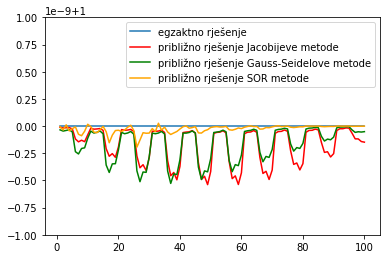

In [37]:
plt.ylim([1-1e-9, 1+1e-9])
plt.plot(xAxis, one, label='egzaktno rješenje')
plt.plot(xAxis, approxJacobi[-1].T, label='približno rješenje Jacobijeve metode', color='red')
plt.plot(xAxis, approxGS[-1].T, label='približno rješenje Gauss-Seidelove metode', color='green')
plt.plot(xAxis, approxSOR[-1].T, label='približno rješenje SOR metode', color='orange')
plt.legend()

# 2. Numeričko rješavanje

## 2.1. Uvod<a name="uvod2"></a>

U mnogim primjenama u prirodnim i inžinjerskim znanostima vremenska promjena stanja promatranog sustava opisuje se diferencijalnim jednadžbama koje matematički opisuju zakone:
$$
\begin{equation}
    y'\left(t\right) = f\left(t,y(t)\right),\; t\geq t_{0}\\
    y\left(t_{0}\right) = y_{0} \label{eq:12}\tag{12}
\end{equation}
$$

Pri tome je $f:I\times\mathbb{R}^{d}\mapsto\mathbb{R}^{d}$, gdje je $I\subseteq\mathbb{R}$ otvoren interval, $t_{0}\in I$, $d\geq 1$ i $y_{0}\in\mathbb{R}^{d}$. Po komponentama, problem $\eqref{eq:12}$ glasi

$$
\begin{pmatrix}
    y'_{1}\left(t\right)\\
    y'_{2}\left(t\right)\\
    \vdots\\
    y'_{d}\left(t\right)
\end{pmatrix}= 
\begin{pmatrix}
    f_{1}\bigl(t,y_{1}\left(t\right),y_{2}\left(t\right),...,y_{d}\left(t\right)\bigr)\\
    f_{2}\bigl(t,y_{1}\left(t\right),y_{2}\left(t\right),...,y_{d}\left(t\right)\bigr)\\
    \vdots\\
    f_{d}\bigl(t,y_{1}\left(t\right),y_{2}\left(t\right),...,y_{d}\left(t\right)\bigr)
\end{pmatrix}, 
\begin{pmatrix}
    y'_{1}\left(t_{0}\right)\\
    y'_{2}\left(t_{0}\right)\\
    \vdots\\
    y'_{d}\left(t_{0}\right)
\end{pmatrix}=
\begin{pmatrix}
    \left(y_{0}\right)_{1}\\
    \left(y_{0}\right)_{2}\\
    \vdots\\
    \left(y_{0}\right)_{n}
\end{pmatrix}
$$

Kažemo da je $\eqref{eq:12}$ inicijalni problem za sustav običnih diferencijalnih jednadžbi. Ako je

$$
f\left(t,x_{1},x_{2},...,x_{d}\right) = A\left(t\right)
\begin{pmatrix}
    x_{1}\\
    x_{2}\\
    \vdots\\
    x_{n}
\end{pmatrix}+
\begin{pmatrix}
    b_{1}\left(t\right)\\
    b_{2}\left(t\right)\\
    \vdots\\
    b_{n}\left(t\right)
\end{pmatrix}$$

onda kažemo da je sustav ODJ linearan.

Kao što sam naslov kaže, naš je cilj riješiti problem $\eqref{eq:12}$ numerički. To znači izračunati aproksimacije vrijednosti u konačno točaka $t_{1},t_{2},...,t_{n}$ u zadanom intervalu $[t_{0},T]$.

Metode rješavanja inicijalnog problema za obične diferencijalne jednadžbe numeričkim aproksimacijama dijelimo na implicitne i eksplicitne te na jednokoračne i višekoračne metode. Eksplicitne metode računaju stanje u idućem vremenskom sloju koristeći trenutni vremenski sloj, dok implicitne metode rješavaju sustav koristeći idući i trenutni vremenski sloj.

Matematički zapisano, ako $Y(t)$ predstavlja stanje u trenutnom vremenskom sloju a $Y(t+\Delta t)$ predstavlja stanje u idućem vremenskom sloju (gdje $\Delta t$ predstavlja mali korak u vremenu, $\Delta t> 0$), tada za eksplicitnu metodu rješavamo sustav oblika

$$ Y\left(t+\Delta t\right) = F\bigl(Y\left(t\right)\bigr) $$

dok za implicitnu metodu rješavamo sustav oblika

$$ G\bigl(Y\left(t\right),Y\left(t+\Delta t\right)\bigr)=0$$

kako bismo dobili $Y\left(t+\Delta t\right)$.

Jednokoračne metode za numeričko rješavanje trenutnog vremenskog sloja koriste samo jedan, prethodni vremenski sloj, dok višekoračne metode za numeričko rješavanje trenutnog vremenskog sloja koriste dio prošlosti, a ne samo prethodni vremenski sloj. Najprije ćemo navesti jednostavne primjere jednokoračnih metoda, a zatim jednu višekoračnu metodu koja koristi $4$ prethodna vremenska sloja. 

Metode koje ćemo navesti i objasniti su Eulerova metoda, trapezna metoda, Runge–Kuttina metoda i Adams–Bashforthova metoda.

## 2.2. Jednokoračne metode <a name="jednokoracne"></a>

### 2.2.1. Eulerova metoda<a name="Euler"></a>

Eulerova metoda najjednostavniji je primjer jednokoračne eksplicitne metode – vrijednost $y_{i+1}$ dobivena je eksplicitnim izrazom koji koristi informaciju samo iz jednog prethodnog koraka $t_{i}$.

Ključni element numeričkog rješavanja inicijalnog problema
$$
\begin{equation}
    y'\left(t\right) = f\bigl(t,y\left(t\right)\bigr),\; t\geq t_{0}\\
    y\left(t_{0}\right) = y_{0}
\end{equation}
$$ 

je kako iskoristiti diferencijalnu jednadžbu i od poznate vrijednosti $y\left(t_{0}\right)$ dobiti što bolju aproksimaciju za $y\left(t_{1}\right)$, i tako sve do $y\left(t_{n}\right)$.

$$ y\left(t_{i+1}\right)-y\left(t_{i}\right) = \int_{t_{i}}^{t_{i+1}}y'\left(\tau\right)d\tau = \int_{t_{i}}^{t_{i+1}} f\bigl(\tau,y\left(\tau\right)\bigr)d\tau. $$

Uočimo da relaciju

$$ y\left(t_{i+1}\right) = y\left(t_{i}\right) + \int_{t_{i}}^{t_{i+1}} f\bigl(\tau,y\left(\tau\right)\bigr)d\tau $$

možemo iskoristiti za aproksimaciju $y\left(t_{i+1}\right)$ tako što ćemo aproksimirati numeričku vrijednost integrala. Istina, vrijednost podintegralne funkcije znamo samo u lijevom rubu intervala $[t_{i},t_{i+1}]$ pa je najjednostavnije što možemo učiniti sljedeće

$$ \int_{t_{i}}^{t_{i+1}} f\bigl(\tau,y\left(\tau\right)\bigr)d\tau \approx \left(t_{i+1}-t_{i}\right)f\bigl(t_{i},y\left(t_{i}\right)\bigr) $$

pa imamo

$$ y\left(t_{i+1}\right) \approx y\left(t_{i}\right) + \left(t_{i+1}-t_{i}\right)f\bigl(t_{i},y\left(t_{i}\right)\bigr). $$

Promotrimo ideju na idućem primjeru. Integral funkcije između točke $t_{i}=1$ i $t_{i+1}=1.3$ aproksimiramo površinom pravokutnika $\left(1.3-1\right)\cdot f\bigl(1,y\left(1\right)\bigr)$. Za dovoljno mali korak $\Delta t$, površina $X$ je zanemarivo mala, razlika površinâ je dovoljno mala, dakle aproksimacija je dovoljno dobra.

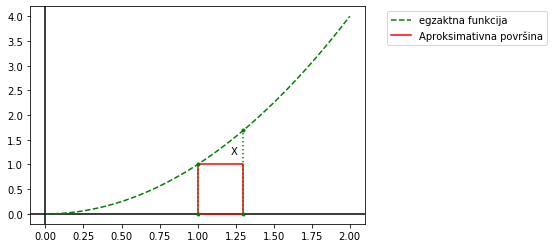

In [60]:
x = np.linspace(0, 2, 201)
fig5, ax = plt.subplots()
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.plot(x, x**2, color='green', linestyle='--', label='egzaktna funkcija')
ax.plot([1., 1., 1.3, 1.3, 1.], [0., 1., 1., 0., 0.], color='red', label='Aproksimativna površina')
ax.plot([1.3, 1.3],[0., 1.69], color='green', linestyle=':', marker = '.')
ax.plot([1., 1.],[0., 1.], color='green', linestyle=':', marker = '.')
ax.text(1.22,1.2, 'X')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Neka je $n$ broj točaka u kojima ćemo aproksimirati rješenje. Diskretne vrijednosti $t_{0},t_{1},...,t_{n}$ možemo birati sa varijabilnim koracima $h_{i}=t_{i+1}-t_{i}$, za sve $i=0,1,...,n$.

Eulerov algoritam:

In [82]:
def euler(f, y, t, T, n):
    """" Računanje približnog rješenja inicijalnog problema za ODJ Eulerovom metodom
    
    Argumenti funkcije:
    f -- funkcija desne strane
    y -- početni uvjet 
    t -- početni trenutak
    T -- završni trenutak
    n -- broj točaka iz [t, T) u kojima računamo aproksimaciju
    """
    
    d = len(y)
    x = np.linspace(t, T, n+1)
    h = (T-t) / n
    solution = np.zeros((d, n+1))
    solution[:, 0] = y
    for i in range(0, n):
        solution[:, i+1] = solution[:, i] + h*f(x[i], solution[:, i])
    return solution

### 2.2.2. Trapezna metoda<a name="trapez"></a>

Trapezna metoda najjednostavniji je primjer jednokoračne implicitne metode. Aproksimativna vrijednost $y\left(t_{i+1}\right)$ dobije se koristeći informaciju u trenutku $t_{i}$ i pri tome je aproksimacija definirana implicitno kao rješenje jednadžbe. Ideja metode je jednostavna: umjesto pravokutnikom, integral u izrazu

$$ y\left(t_{i+1}\right) = y\left(t_{i}\right) + \int_{t_{i}}^{t_{i+1}} f\bigl(\tau,y\left(\tau\right)\bigr)d\tau $$

aproksimiramo površinom

$$ \int_{t_{i}}^{t_{i+1}} f\bigl(\tau,y\left(\tau\right)\bigr)d\tau \approx \frac{t_{i+1}-t_{i}}{2}\bigl(f\bigl(t_{i},y\left(t_{i}\right)\bigr)+f\bigl(t_{i+1},y\left(t_{i+1}\right)\bigr)\bigr) $$

Primjerom kojim smo se poslužili za Eulerovu metodu, imamo

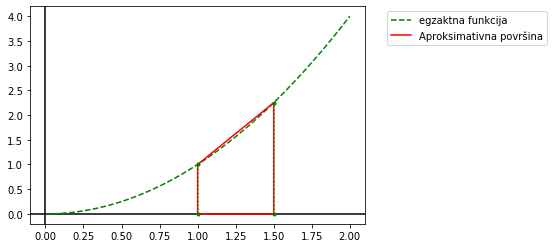

In [62]:
x = np.linspace(0, 2, 201)
fig6, ax1 = plt.subplots()
ax1.axhline(y=0, color='k')
ax1.axvline(x=0, color='k')
ax1.plot(x, x**2, color='green', linestyle='--', label='egzaktna funkcija')
ax1.plot([1., 1., 1.5, 1.5, 1.], [0., 1., 2.25, 0., 0.], color='red', label='Aproksimativna površina')
ax1.plot([1.5, 1.5],[0., 2.25], color='green', linestyle=':', marker = '.')
ax1.plot([1., 1.],[0., 1.], color='green', linestyle=':', marker = '.')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

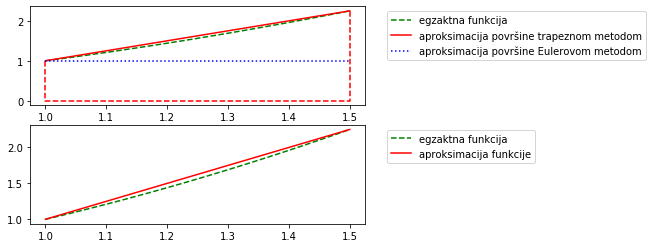

In [63]:
y = x[100:151]
fig7, (ax2, ax3) = plt.subplots(2,1)
ax2.plot(y, y**2, color='green', linestyle='--', label='egzaktna funkcija')
ax2.plot([1., 1.5], [1.,2.25], color='red', label='aproksimacija površine trapeznom metodom')
ax2.plot([1., 1., 1.5, 1.5], [1., 0., 0., 2.25], color='red', linestyle='--')
ax2.plot([1., 1.5],[1., 1.], color='blue', linestyle=':', label='aproksimacija površine Eulerovom metodom')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.plot(y, y**2, color='green', linestyle='--', label='egzaktna funkcija')
ax3.plot([1., 1.5], [1.,2.25], color='red', label='aproksimacija funkcije')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Vidmo kako je površina između egzaktne funkcije i aproksimacije trapeznom metodom manja nego površina između egzaktne funkcije i aproksimacije Eulerovom metodom.

Algoritam trapezne metode:

In [84]:
from scipy.optimize import fsolve
def trapeze(f, y, t, T, n):
    """" Računanje približnog rješenja inicijalnog problema za ODJ trapeznom metodom
    
    Argumenti funkcije:
    f -- funkcija desne strane
    y -- početni uvjet 
    t -- početni trenutak
    T -- završni trenutak
    n -- broj točaka iz [t, T) u kojima računamo aproksimaciju
    """
    
    d = len(y)
    x = np.linspace(t, T, n+1)
    h = (T-t) / n
    solution = np.zeros((d, n+1))
    solution[:, 0] = y
    h = h / 2
    for i in range(0, n):
        def fun(g):
            return g - solution[:,i] - h*(f(x[i], solution[:,i]) + f(x[i+1], g))
        solution[:, i+1] = sp.optimize.fsolve(fun, solution[:, i])
    return solution

### 2.2.2. Runge–Kuttina metoda<a name="runge"></a>

Želja nam je poboljšati jednostavne jednokoračne metode. Polazimo od osnovne relacije

$$ y\left(t_{i+1}\right) = y\left(t_{i}\right) + \int_{t_{i}}^{t_{i+1}} f\bigl(\tau,y\left(\tau\right)\bigr)d\tau $$

i u njoj pokušavamo aproksimirati numeričku vrijednost integrala koristeći dodatne čvorove u $\left[t_{k},t_{k+1}\right]$ i dodatne slobodne parametre koje ćemo naknadno namjestiti kako bismo dobili na točnosti. Konkretno, uzmimo na primjer tri čvora $\xi_{1}, \xi_{2}, \xi_{3}$, tri dodatna parametra $c_{1},c_{2},c_{3}$ i potražimo formulu oblika

$$ y_{k+1}=y_{k} + h\bigl(c_{1}f\bigl(\xi_{1}, y\left(\xi_{1}\right)\bigr) + c_{2}f\bigl(\xi_{2}, y\left(\xi_{2}\right)\bigl) + c_{3}f\bigl(\xi_{3}, y\left(\xi_{3}\right)\bigr)\bigr).$$

Odaberimo $\xi_{1}=t_{k}, \xi_{2}=t_{k}+a_{2}h, \xi_{3}=t_{k}+a_{3}h \text{ za } 0<a_{2},a_{3}<1.$

Kako nam vrijednost $y\left(\xi_{i}\right)$ nisu dostupne, zamijenit ćemo ih slobodnim parametrima $A_{21}, A_{31}, A_{31}$:

$$
\begin{equation}
    y\left(\xi_{1}\right) \approx y_{k}\\
    y\left(\xi_{2}\right) \approx y_{k} + hA_{21}f\left(t_{k}, y_{k}\right)\\
    y\left(\xi_{1}\right) \approx y_{k} + hA_{31}f\left(t_{k}, y_{k}\right) + hA_{32}f\bigl(t_{k}+a_{2}h, y_{k} + hA_{21}f\left(t_{k}, y_{k}\right)\bigr).
\end{equation}
$$

Odavde dobivamo opći oblik k–tog koraka:

$$
\begin{equation}
    \Psi_{1} = f\left(t_{k}, y_{k}\right)\\
    \Psi_{2} = f\left(t_{k} + a_{2}h, y_{k}+hA_{21}\Psi_{1}\right)\\
    \Psi_{3} = f\bigl(t_{k} + a_{3}h, y_{k} + h\left(A_{31}\Psi_{1} + A_{32}\Psi_{2}\right)\bigl)\\
    y_{k+1} = y_{k} + h\left(c_{1}\Psi_{1} + c_{2}\Psi_{2} + c_{3}\Psi_{3}\right).
\end{equation}
$$

Na prvi pogled djeluje kao da smo jako zakomplicirali Runge–Kuttinom metodom, ali zapravo smo dobili veći red metode. Drugim rječima, za jednak broj točaka subdivizije, dobit ćemo veću točnost, tj. manju grešku aproksimacije. To će nam biti korisno za Adams–Bashforthovu metodu, jer će se greška gomilati, a Runge–Kuttinom metodom ćemo "nagomilati manju grešku" u početnim iteracijama. No, hajdemo prvo napisati algoritam Runge–Kuttine metode:

In [106]:
def rungeKutta(f, y, t, T, n):
    """" Računanje približnog rješenja inicijalnog problema za ODJ Runge-Kuttinom metodom
    
    Argumenti funkcije:
    f -- funkcija desne strane
    y -- početni uvjet 
    t -- početni trenutak
    T -- završni trenutak
    n -- broj točaka iz [t, T) u kojima računamo aproksimaciju
    """
    
    # inicijalizacija varijabli radi bolje čitljivosti koda
    a1 = 0.
    a2 = 0.5
    a3 = 0.5
    a4 = 1.
    A21 = 0.5
    A31 = 0.
    A32 = 0.5
    A41 = 0.
    A42 = 0.
    A43 = 1.
    c1 = 1/6
    c2 = 1/3
    c3 = 1/3
    c4 = 1/6
    
    d = len(y)
    x = np.linspace(t, T, n+1)
    h = (T-t) / n
    solution = np.zeros((d, n+1))
    solution[:, 0] = y
    for i in range(0,n):
        psi1 = f(x[i], solution[:,i])
        psi2 = f(x[i] + h*a2, solution[:, i] + h*psi1*A21)
        psi3 = f(x[i] + h*a3, solution[:, i] + h*(psi1*A31 + psi2*A32))
        psi4 = f(x[i] + h*a4, solution[:, i] + h*(psi1*A41 + psi2*A42 + psi3*A43))
        solution[:, i+1] = solution[:, i] + h*(c1*psi1 + c2*psi2 + c3*psi3 + c4*psi4)
    return solution

## 2.3. Višekoračne metode<a name="visekoracne"></a>

Kao što je gore već spomenuto, višekoračne metode za numeričko rješavanje trenutnog vremenskog sloja koriste dio prošlosti, a ne samo prethodni vremenski sloj. U ovom radu proći ćemo samo jednu takvu metodu, ali u [Literaturi](#Literatura) se nalazi više različitih linkova putem kojih možete saznati puno više o raznim drugim (višekoračnim) metodama.

### 2.3.1. Adams–Bashforthova metoda<a name="Adams"></a>

Za relaciju

$$ y\left(t_{i+1}\right) = y\left(t_{i}\right) + \int_{t_{i}}^{t_{i+1}} f\bigl(\tau,y\left(\tau\right)\bigr)d\tau $$

kreiranjem Lagrangeovog interpolacijskog polinoma dobivamo

$$ P_{3}\left(t\right) = \sum_{j = 0}^{3}f\left(t_{k-j}, y_{k-j}\right)L_{k-j}\left(t\right) $$

gdje je 

$$ L_{k-j}\left(t\right) = \frac{\prod_{i\neq k-j}\left(t-t_{i}\right)}{\prod_{i\neq k-j}\left(t_{k-j}-t_{i}\right)}.$$

Iskoristimo Lagrangeov interpolacijski integral za aproksimaciju podintegralne funkcije na $\left[t_{k},t_{k+1}\right].$ Time smo definirali metodu oblika

$$ y_{k+1} = y_{k} + \sum_{j = 0}^{3}f\left(t_{k-j}, y_{k-j}\right)\int_{t_{k}}^{t_{k+1}}L_{k-j}\left(\tau\right)d\tau.$$

Označimo $p_{j} = \int_{t_{k}}^{t_{k+1}}L_{k-j}\left(\tau\right)d\tau.$ Jednostavnim računom dobivamo:
$$
p_{0} = \frac{55}{24}h\\
p_{1} = -\frac{59}{24}h\\
p_{2} = \frac{37}{24}h\\
p_{3} = -\frac{9}{24}h
$$

gdje je $h$ korak ekvidistantne mreže.

Kao što smo spomenuli u dijelu o Runge–Kuttinoj metodi, želimo "nagomilati manju grešku" pa ćemo prve četiri vrijednosti izračunati koristeći Runge–Kuttinu metodu kako bismo uopće i mogli koristiti Adams–Bashforthovu metodu.

Algoritam Adams–Bashforthove metode:

In [143]:
def adamsBashforth(f, y, t, T, n):
    """" Računanje približnog rješenja inicijalnog problema za ODJ Adams-Bashforthovom metodom
    
    Argumenti funkcije:
    f -- funkcija desne strane
    y -- početni uvjet 
    t -- početni trenutak
    T -- završni trenutak
    n -- broj točaka iz [t, T) u kojima računamo aproksimaciju
    """
    
    d = len(y)
    x = np.linspace(t, T, n+1)
    h = (T-t) / n
    h24 = h / 24
    solution = np.zeros((d, n+1))
    solution[:, 0:4] = rungeKutta(f, y, t, t + 3*h, 3)
    for i in range(3,n):
        solution[:, i+1] = solution[:, i] + h24*(55*f(x[i], solution[:, i])
                                                 - 59*f(x[i-1], solution[:, i-1])
                                                 + 37*f(x[i-2], solution[:, i-2])
                                                 - 9*f(x[i-3], solution[:, i-3]))
    return solution

## 2.4. Testiranje i usporedba na primjerima<a name="Testiranje2"></a>

### $f\left(t, x\right) = \bigl(x_{1} - 2x_{2} + 4cos\left(t\right) - 2sin\left(t\right),\;\;3x_{1} - 4x_{2} + 5cos\left(t\right) - 5sin\left(t\right)\bigr)$

In [178]:
def f(t, x):
    g = np.array([x[0] - 2*x[1] + 4*np.cos(t) - 2*np.sin(t), 3*x[0] - 4*x[1] + 5*np.cos(t) - 5*np.sin(t)])
    return g
y = np.array([1, 2])
t = 0
T = 6 * np.pi
n = 151
x = np.linspace(t, T, n+1)
exact = np.zeros((len(y), len(x)))
exact[0] = np.cos(x) + np.sin(x)
exact[1] = 2 * np.cos(x)

In [179]:
%time yEuler = euler(f, y, t, T, n)
%time yTrapeze = trapeze(f, y, t, T, n)
%time yRK = rungeKutta(f, y, t, T, n)
%time yAB = adamsBashforth(f, y, t, T, n)

Wall time: 10.1 ms
Wall time: 40.4 ms
Wall time: 12.1 ms
Wall time: 10.8 ms


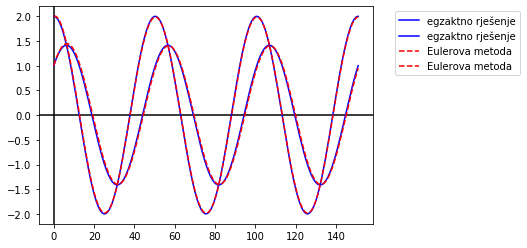

In [195]:
fig8, ax = plt.subplots()

# postavljanje koordinatnih osi na plot
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

ax.plot(exact.T, color='blue', label='egzaktno rješenje')
ax.plot(yEuler.T, color='red', linestyle='--', label='Eulerova metoda')
        
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

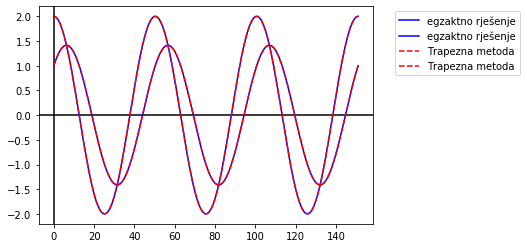

In [196]:
fig9, ax = plt.subplots()

# postavljanje koordinatnih osi na plot
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

ax.plot(exact.T, color='blue', label='egzaktno rješenje')
ax.plot(yTrapeze.T, color='red', linestyle='--', label='Trapezna metoda')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

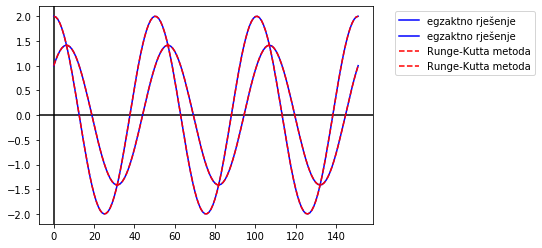

In [197]:
fig10, ax = plt.subplots()

# postavljanje koordinatnih osi na plot
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

ax.plot(exact.T, color='blue', label='egzaktno rješenje')
ax.plot(yRK.T, color='red', linestyle='--', label='Runge-Kutta metoda')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

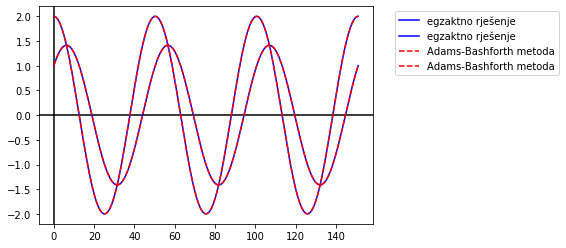

In [200]:
fig11, ax = plt.subplots()

# postavljanje koordinatnih osi na plot
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

ax.plot(exact.T, color='blue', label='egzaktno rješenje')
ax.plot(yAB.T, color='red', linestyle='--', label='Adams-Bashforth metoda')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Izračunajmo sada još i koliko naše aproksimacije odstupaju od vrijednosti egzaktnog rješenja u točkama u kojima aproksimiramo:

In [184]:
errorEuler = max(np.linalg.norm(yEuler[0] - exact[0], np.inf), np.linalg.norm(yEuler[1] - exact[1], np.inf))
errorTrapeze = max(np.linalg.norm(yTrapeze[0] - exact[0], np.inf), np.linalg.norm(yTrapeze[1] - exact[1], np.inf))
errorRK = max(np.linalg.norm(yRK[0] - exact[0], np.inf), np.linalg.norm(yRK[1] - exact[1], np.inf))
errorAB = max(np.linalg.norm(yAB[0] - exact[0], np.inf), np.linalg.norm(yAB[1] - exact[1], np.inf))
print('\nGreška Eulerove metode: ', errorEuler)
print('\nGreška Trapezne metode: ', errorTrapeze)
print('\nGreška Runge-Kutta metode: ', errorRK)
print('\nGreška Adams-Bashforth metode: ', errorAB)


Greška Eulerove metode:  0.07373374966988025

Greška Trapezne metode:  0.0013190459717520309

Greška Runge-Kutta metode:  3.7118763241972275e-05

Greška Adams-Bashforth metode:  8.692342751870363e-05


# 3. Literatura<a name="Literatura"></a>

<b> Prvi dio </b>

Iterativne metode: https://en.wikipedia.org/wiki/Iterative_method

Jacobijeva metoda: https://en.wikipedia.org/wiki/Jacobi_method

Gauss–Seidelova metoda: https://en.wikipedia.org/wiki/Gauss%E2%80%93Seidel_method

SOR metoda: https://en.wikipedia.org/wiki/Successive_over-relaxation

Stieltjes matrica: https://en.wikipedia.org/wiki/Stieltjes_matrix i https://web.math.pmf.unizg.hr/~nela/zr1.html

Dodavanje oznaka na barove u bar chartu: https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart/48372659

Bojanje barova u bar chartu: https://stackoverflow.com/questions/18973404/setting-different-bar-color-in-matplotlib-python

Matplotlib dokumentacija: https://matplotlib.org/

Numpy dokumentacija: https://docs.scipy.org/doc/numpy/index.html

Kreiranje videa: https://gifmaker.me/

Matrični zapis iterativnih metodâ: https://web.math.pmf.unizg.hr/~nela/zr1vjezbe/zr1_iterativne_metode.pdf

Teoretska pozadina numeričkog rješavanja sustava linearnih jednadžbi: https://web.math.pmf.unizg.hr/~drmac/na001.pdf

<b> Drugi dio </b>

Teoretska pozadina numeričkog rješavanja inicijalnog problema za ODJ: https://web.math.pmf.unizg.hr/~drmac/b0.pdf i https://web.math.pmf.unizg.hr/~nela/zr2.html

Eksplicitne i implicitne metode: https://en.wikipedia.org/wiki/Explicit_and_implicit_methods

Eulerova metoda: https://en.wikipedia.org/wiki/Euler_method

Trapezna metoda: https://en.wikipedia.org/wiki/Trapezoidal_rule

Runge–Kuttina metoda: https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods

Adams–Bashforthova metoda: https://en.wikipedia.org/wiki/Linear_multistep_method#Adams%E2%80%93Bashforth_methods

Prikazivanje osi u plotu: https://stackoverflow.com/questions/25689238/show-origin-axis-x-y-in-matplotlib-plot

scipy.optimize.fsolve: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fsolve.html